In [20]:
using StaticArrays
using LinearAlgebra
# using Makie
using LsqFit
include("src\\Elastic.jl")
using .Elastic
using DelimitedFiles
using Distributions
using Statistics
using Plots
using Test
using IterTools
using BenchmarkTools
using LaTeXStrings
using JSON

In [2]:
atom_positions = [
    Vector([0.0, 0.0, 0.0]),
    Vector([0.0, 0.5, 0.5]),
    Vector([0.5, 0.0, 0.5]),
    Vector([0.5, 0.5, 0.0]),
    Vector([1.0, 0.0, 0.0]),
    Vector([0.0, 1.0, 0.0]),
    Vector([0.0, 0.0, 1.0]),
    Vector([0.5, 1.0, 0.5]),
    Vector([1.0, 0.5, 0.5]),
    Vector([0.5, 0.5, 1.0]),
    Vector([1.0, 0.0, 1.0]),
    Vector([1.0, 1.0, 0.0]),
    Vector([0.0, 1.0, 1.0]),
    Vector([1.0, 1.0, 1.0])
] 
kb=8.617332385e-5 #eV/K
amuM=1.03642701e-4 #[m]/amu
Mcu=26.9815385 #amu
lattice_constant = 4.032 #A

# 定义铜的FCC晶胞的基矢量
lattice_vectors = collect((Matrix([
    lattice_constant 0.0 0.0; #a1
    0.0 lattice_constant 0.0; #a2
    0.0 0.0 lattice_constant] #a3
))')

# 创建铜的原子列表
atoms = [Atom(pos,Mcu*amuM) for pos in atom_positions]


cell=UnitCell(lattice_vectors,atoms)
cpcell=copycell(cell,2,2,2)
fcell=filtercell(cpcell)
visualize_unitcell_atoms(fcell)
ct=6.5
embeddingAl2=Embedding(embedding_energyAl2, embedding_forceAl2i)
interaction=Interaction(EMAAl2_phi, EMAAl2_phi_gradient, ct, 0.1, embeddingAl2)
# interaction=Interaction(EMAAl2_phi, EMAAl2_phi_gradient, ct, 0.1)
xx=3.5:0.001:6.5
y=interaction.cutenergy.(xx)
Plots.plot(xx,y,label="",xlabel=L"r_{ij}/\mathrm{\AA}",ylabel=L"\phi/\mathrm{eV}",title=L"\phi-r_{ij}", xlabelfontsize=14, ylabelfontsize=14, titlefontsize=16,lw=2)
cl,El=minimizeEnergy!(fcell, interaction,rg=[3.8,4.5])

(3.8:0.0007007007007007007:4.5, [-832.0950777254744, -832.4470398733647, -832.7982714090572, -833.1487623701771, -833.498502805012, -833.8474827731527, -834.1956923481036, -834.5431216214242, -834.8897607071168, -835.2355997394135  …  -820.5523646244695, -820.3908921046163, -820.2290992431886, -820.0669890592837, -819.9045645819344, -819.7418288485662, -819.5787849077683, -819.4154358142646, -819.251784631304, -819.0878344293711])

In [4]:
Fstd=zeros(3,3)
# Fstd=Force_Tensor(fcell,interaction,dr=BigFloat("1e-9"))

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [24]:
P00=160.2176565 #Gpa/[p]
projectname="Deformer_output\\deform_dimaond_111_1"
Logpath=projectname*"\\Log.json"
configpath=projectname*"\\Config.txt"
results = read_json(Logpath);
flaglist=eval(Meta.parse(read_config(configpath, "flaglist=")))
tol=0.01

if !isdir("$projectname\\LogFig\\")
    mkpath("$projectname\\LogFig\\")
end

Fltotal=Array{Matrix}([])
dltotal=Array{Vector}([])

for flag in flaglist
    dl2=Vector{Float64}([])
    Fl2=Matrix{Float64}(undef, 6, 0)
    for re in results
        if re["flag"]==flag
            # push!(Ul2,Float64(re["dUdhij"]))
            Ft=re["forcetensor"]
            Fl2=hcat(Fl2,-(FT2sigma(Ft)+FT2sigma(Matrix(Fstd))))
            push!(dl2,Float64(re["delta"]))
        end
    end
    push!(Fltotal,Fl2)
    push!(dltotal,dl2)
    ep=(DF2elastic(flag,1.0))
    indices = findall(x -> abs(x) > tol, ep)
    for k in indices
    xx=[(DF2elastic(flag,i))[k] for i in dl2]
    p=Plots.plot(xx,Fl2[1,:],lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,dpi=600,label=L"\sigma_1",xlabel=latexstring("\\epsilon_$k"),ylabel=L"\sigma/\mathrm{Gpa}",title="Stress-Strain Relationship for Deformation $flag"
    , xlabelfontsize=14, ylabelfontsize=14, titlefontsize=12)
    for i in 2:6
    # label_text = L"\sigma_{" * string(flag) * "}" 
    label_text=latexstring("\\sigma_$i")
    Plots.plot!(p,xx,Fl2[i,:].*P00,lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,label=label_text)
    end
    Plots.savefig(p,"$projectname\\LogFig\\Flag=$flag _eps$k.png")
    end
end

In [30]:
ep1=Matrix{Float64}(undef, 6, 0)
ep2=Matrix{Float64}(undef, 6, 0)
s1=Matrix{Float64}(undef, 6, 0)
s2=Matrix{Float64}(undef, 6, 0)

for flag in flaglist
    if flag>0
        dl2=dltotal[flag+1]
        Fl2=Fltotal[flag+1]
        ep1=hcat(ep1,DF2elastic(flag,dl2[end]))
        ep2=hcat(ep2,DF2elastic(flag,dl2[1]))
        s1=hcat(s1,Fl2[:,end])
        s2=hcat(s2,Fl2[:,1])
    end
end



BoundsError: BoundsError: attempt to access 0-element Vector{Float64} at index [0]

In [32]:
dltotal

6-element Vector{Vector}:
 [-0.005, -0.0044736842105263155, -0.003947368421052632, -0.0034210526315789475, -0.0028947368421052633, -0.002368421052631579, -0.0018421052631578947, -0.0013157894736842105, -0.0007894736842105263, -0.0002631578947368421, 0.0002631578947368421, 0.0007894736842105263, 0.0013157894736842105, 0.0018421052631578947, 0.002368421052631579, 0.0028947368421052633, 0.0034210526315789475, 0.003947368421052632, 0.0044736842105263155, 0.005]
 [-0.005, -0.0044736842105263155, -0.003947368421052632, -0.0034210526315789475, -0.0028947368421052633, -0.002368421052631579, -0.0018421052631578947, -0.0013157894736842105, -0.0007894736842105263, -0.0002631578947368421, 0.0002631578947368421, 0.0007894736842105263, 0.0013157894736842105, 0.0018421052631578947, 0.002368421052631579, 0.0028947368421052633, 0.0034210526315789475, 0.003947368421052632, 0.0044736842105263155, 0.005]
 [-0.005, -0.0044736842105263155, -0.003947368421052632, -0.0034210526315789475, -0.002894736842105263

DF2elastic (generic function with 2 methods)

In [16]:
C1=s1*inv(ep1).*P00

6×6 Matrix{Float64}:
 1087.57          136.269        …   19.5528        19.5528
  136.267        1087.57             20.1322        19.5401
  136.267         136.267            19.5388        20.131
    1.39454e-12     2.74681e-13       0.000462945   -6.4173e-12
    1.26776e-13     1.71148e-12     482.161         -2.54405e-13
   -2.11293e-13    -1.50168e-12  …   -4.26003e-14  482.159

In [18]:
C2=s2*inv(ep2).*P00

6×6 Matrix{Float64}:
 1049.85           97.288        …  -19.5716       -19.5716
   97.2904       1049.85            -20.1529       -19.5583
   97.2904         97.2904          -19.5596       -20.1517
    4.23009e-14     1.69204e-12      -0.000774322   -7.72022e-13
    1.60744e-12     2.11505e-13     482.159         -8.02959e-13
    3.17257e-12     4.22586e-14  …    4.45199e-13  482.159

In [19]:
(C1+C2)/2

6×6 Matrix{Float64}:
 1068.71          116.778        …   -0.00942989    -0.00943051
  116.779        1068.71             -0.0103629     -0.0091256
  116.779         116.779            -0.0103629     -0.0103629
    7.18418e-13     9.83359e-13      -0.000155689   -3.59466e-12
    8.67106e-13     9.6149e-13      482.16          -5.28682e-13
    1.48064e-12    -7.29712e-13  …    2.01299e-13  482.159

In [11]:

re=Dict("C1"=>C1,"C2"=>C2,"(C1+C2)/2"=>(C1+C2)/2)
open("$projectname\\results.json","w") do io
    write(io,JSON.json(re))
end

2295

In [12]:
floor(length(dltotal[1])/2)

2.0

In [13]:
Clo=Vector{Float64}([])
Cln=Vector{Float64}([])
Cla=Vector{Float64}([])
x=Vector{Float64}([])
for i in 1:Int(floor(length(dltotal[1])/2))
    ep1=Matrix{Float64}(undef, 6, 0)
    ep2=Matrix{Float64}(undef, 6, 0)
    s1=Matrix{Float64}(undef, 6, 0)
    s2=Matrix{Float64}(undef, 6, 0)

    for flag in flaglist
        dl2=dltotal[flag]
        Fl2=Fltotal[flag]

        ep1=hcat(ep1,DF2elastic(flag,dl2[end-i]))
        ep2=hcat(ep2,DF2elastic(flag,dl2[i]))
        s1=hcat(s1,Fl2[:,end-i])
        s2=hcat(s2,Fl2[:,i])
    end
    push!(x,abs(dltotal[1][i]))
    Cl1=s1*inv(ep1).*P00
    Cl2=s2*inv(ep2).*P00
    Cl3=(Cl1+Cl2)/2
    push!(Clo,Cl1[1,1])
    push!(Cln,Cl2[1,1])
    push!(Cla,Cl3[1,1])
end


SingularException: SingularException(1)

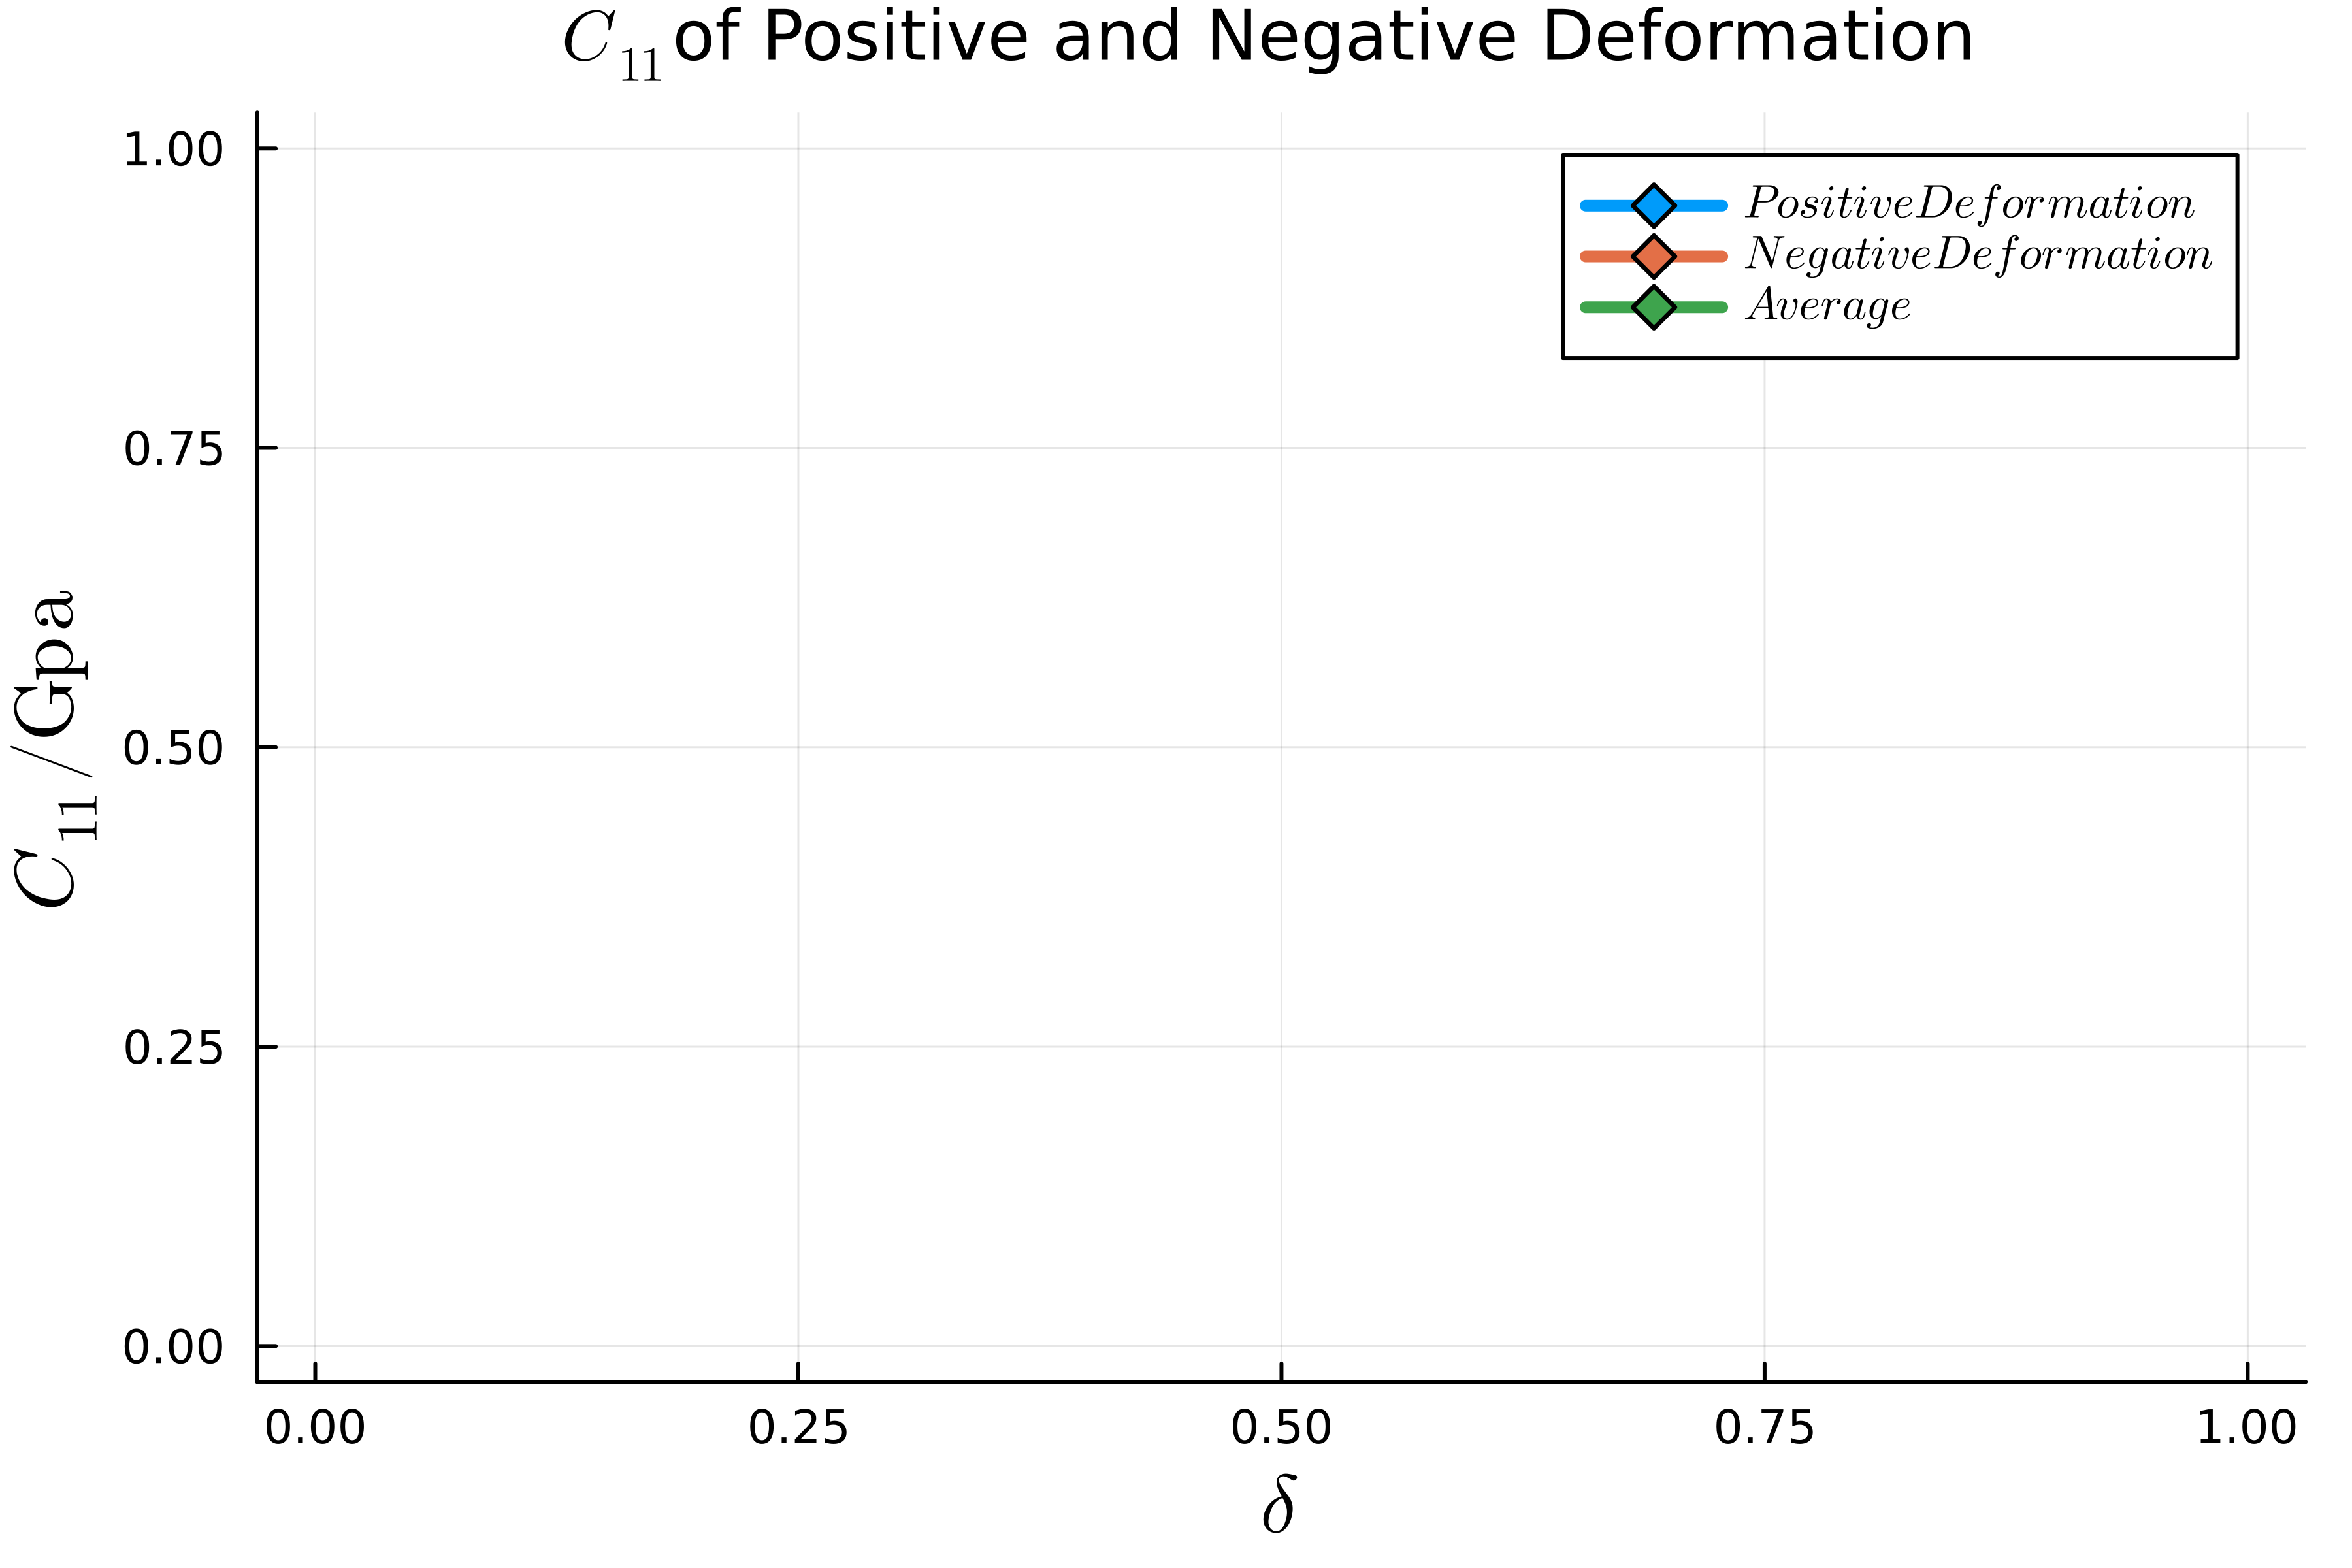

In [17]:
p=plot(x,Clo,lw=3,alpha=1,marker=(:diamond, 4),seriestype=:path,dpi=600,label=L"Positive Deformation",xlabel=L"\delta",ylabel=L"C_{11}/\mathrm{Gpa}",title=L"C_{11}"*"of Positive and Negative Deformation ",xlabelfontsize=14, ylabelfontsize=14, titlefontsize=12)
plot!(x,Cln,lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,label=L"Negative Deformation")
plot!(x,Cla,lw=3,alpha=1,marker=(:diamond, 4), seriestype=:path,label=L"Average")
savefig("$projectname\\LogFig\\diff.png")
p